# Loop 30 Strategic Analysis: Reference Score Comparison

Comparing our current solution against Paul Jurczak's reference scores to identify improvement targets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Paul Jurczak reference scores (from discussion 651069)
paul_jurczak_scores_raw = '''1  0.8132 x 0.8132  0.0000%  score: 0.6612
  2  0.9495 x 0.9495  0.0000%  score: 0.4508
  3  1.1420 x 1.1420  0.0000%  score: 0.4347
  4  1.2909 x 1.2909  0.0000%  score: 0.4166
  5  1.4440 x 1.4440  0.0000%  score: 0.4171
  6  1.5492 x 1.5492  0.0001%  score: 0.4000
  7  1.6738 x 1.6738  0.0000%  score: 0.4002
  8  1.7593 x 1.7500  0.5332%  score: 0.3869
  9  1.8620 x 1.8521  0.5355%  score: 0.3852
 10  1.9420 x 1.9407  0.0710%  score: 0.3772
 11  2.0350 x 2.0341  0.0423%  score: 0.3765
 12  2.1169 x 2.1157  0.0558%  score: 0.3734
 13  2.2030 x 2.2030  0.0000%  score: 0.3733
 14  2.3064 x 2.2819  1.0737%  score: 0.3800
 15  2.3741 x 2.3633  0.4589%  score: 0.3758
 16  2.4431 x 2.4408  0.0967%  score: 0.3731
 17  2.5109 x 2.5109  0.0017%  score: 0.3709
 18  2.5800 x 2.5717  0.3216%  score: 0.3698
 19  2.6400 x 2.6245  0.5889%  score: 0.3668
 20  2.7300 x 2.7250  0.1807%  score: 0.3726
 21  2.8100 x 2.7907  0.6908%  score: 0.3760
 22  2.8917 x 2.8841  0.2644%  score: 0.3801
 23  2.9182 x 2.9182  0.0000%  score: 0.3703
 24  2.9684 x 2.9683  0.0025%  score: 0.3671
 25  3.0451 x 3.0450  0.0037%  score: 0.3709
 26  3.1008 x 3.0987  0.0662%  score: 0.3698
 27  3.1616 x 3.1605  0.0330%  score: 0.3702
 28  3.2061 x 3.1931  0.4084%  score: 0.3671
 29  3.2774 x 3.2643  0.3987%  score: 0.3704
 30  3.2900 x 3.2882  0.0554%  score: 0.3608
 31  3.3700 x 3.3700  0.0000%  score: 0.3663
 32  3.4294 x 3.4294  0.0000%  score: 0.3675
 33  3.4843 x 3.4843  0.0000%  score: 0.3679
 34  3.5455 x 3.5455  0.0001%  score: 0.3697
 35  3.5826 x 3.5826  0.0000%  score: 0.3667
 36  3.6016 x 3.6016  0.0000%  score: 0.3603
 37  3.6733 x 3.6733  0.0000%  score: 0.3647
 38  3.7274 x 3.7274  0.0000%  score: 0.3656
 39  3.7649 x 3.7649  0.0000%  score: 0.3634
 40  3.8399 x 3.8399  0.0000%  score: 0.3686
 41  3.8700 x 3.8635  0.1679%  score: 0.3653
 42  3.9301 x 3.9177  0.3153%  score: 0.3678
 43  3.9758 x 3.9756  0.0070%  score: 0.3676
 44  4.0388 x 4.0020  0.9174%  score: 0.3707
 45  4.0614 x 4.0511  0.2535%  score: 0.3666
 46  4.1044 x 4.0965  0.1940%  score: 0.3662
 47  4.1717 x 4.0684  2.5405%  score: 0.3703
 48  4.2123 x 4.1918  0.4893%  score: 0.3697
 49  4.2377 x 4.1958  0.9992%  score: 0.3665
 50  4.2500 x 4.2474  0.0617%  score: 0.3612'''

# Parse the scores
paul_scores = []
for line in paul_jurczak_scores_raw.strip().split('\n'):
    parts = line.strip().split('score:')
    if len(parts) == 2:
        score = float(parts[1].strip())
        paul_scores.append(score)

print(f"Parsed {len(paul_scores)} Paul Jurczak scores")
print(f"N=1-10: {paul_scores[:10]}")
print(f"Sum N=1-50: {sum(paul_scores):.6f}")

Parsed 50 Paul Jurczak scores
N=1-10: [0.6612, 0.4508, 0.4347, 0.4166, 0.4171, 0.4, 0.4002, 0.3869, 0.3852, 0.3772]
Sum N=1-50: 19.097400


In [4]:
# Load our current submission and calculate per-N scores
import math
from shapely.geometry import Polygon
from shapely.affinity import rotate, translate

# Tree vertices in canonical position
TREE_VERTICES = [
    (0.0, 0.8), (0.125, 0.5), (0.0625, 0.5), (0.2, 0.25), (0.1, 0.25),
    (0.35, 0.0), (0.075, 0.0), (0.075, -0.2), (-0.075, -0.2), (-0.075, 0.0),
    (-0.35, 0.0), (-0.1, 0.25), (-0.2, 0.25), (-0.0625, 0.5), (-0.125, 0.5),
]

def create_tree_polygon(cx, cy, angle_deg):
    tree = Polygon(TREE_VERTICES)
    tree = rotate(tree, angle_deg, origin=(0, 0))
    tree = translate(tree, cx, cy)
    return tree

def get_bounding_box_side(trees):
    """Get the side length of the bounding square."""
    min_x = min_y = float('inf')
    max_x = max_y = float('-inf')
    for tree in trees:
        bounds = tree.bounds  # (minx, miny, maxx, maxy)
        min_x = min(min_x, bounds[0])
        min_y = min(min_y, bounds[1])
        max_x = max(max_x, bounds[2])
        max_y = max(max_y, bounds[3])
    return max(max_x - min_x, max_y - min_y)

def load_submission(filepath):
    df = pd.read_csv(filepath)
    all_xs, all_ys, all_degs = [], [], []
    for n in range(1, 201):
        prefix = f"{n:03d}_"
        group = df[df["id"].str.startswith(prefix)].sort_values("id")
        for _, row in group.iterrows():
            x = float(str(row["x"])[1:]) if str(row["x"]).startswith('s') else float(row["x"])
            y = float(str(row["y"])[1:]) if str(row["y"]).startswith('s') else float(row["y"])
            deg = float(str(row["deg"])[1:]) if str(row["deg"]).startswith('s') else float(row["deg"])
            all_xs.append(x)
            all_ys.append(y)
            all_degs.append(deg)
    return all_xs, all_ys, all_degs

def calculate_per_n_scores(all_xs, all_ys, all_degs):
    scores = []
    idx = 0
    for n in range(1, 201):
        trees = [create_tree_polygon(all_xs[idx + i], all_ys[idx + i], all_degs[idx + i]) for i in range(n)]
        side = get_bounding_box_side(trees)
        score = side * side / n
        scores.append(score)
        idx += n
    return scores

print("Loading submission...")
all_xs, all_ys, all_degs = load_submission('/home/submission/submission.csv')
print(f"Loaded {len(all_xs)} tree positions")

Loading submission...


Loaded 20100 tree positions


In [5]:
# Calculate our per-N scores
print("Calculating per-N scores...")
our_scores = calculate_per_n_scores(all_xs, all_ys, all_degs)
print(f"Calculated {len(our_scores)} scores")
print(f"Our total: {sum(our_scores):.6f}")
print(f"Our N=1-50 sum: {sum(our_scores[:50]):.6f}")

Calculating per-N scores...


Calculated 200 scores
Our total: 70.624381
Our N=1-50 sum: 19.033316


In [6]:
# Compare our scores with Paul Jurczak's for N=1-50
print("\n" + "="*80)
print("COMPARISON: Our scores vs Paul Jurczak reference (N=1-50)")
print("="*80)
print(f"{'N':>4} {'Ours':>10} {'Paul':>10} {'Gap':>10} {'Gap%':>8}")
print("-"*50)

total_gap = 0
for n in range(1, 51):
    our = our_scores[n-1]
    paul = paul_scores[n-1]
    gap = our - paul
    gap_pct = (gap / paul) * 100 if paul > 0 else 0
    total_gap += gap
    if gap > 0.001:  # Highlight significant gaps
        print(f"{n:>4} {our:>10.6f} {paul:>10.6f} {gap:>10.6f} {gap_pct:>7.2f}% ***")
    else:
        print(f"{n:>4} {our:>10.6f} {paul:>10.6f} {gap:>10.6f} {gap_pct:>7.2f}%")

print("-"*50)
print(f"Total gap (N=1-50): {total_gap:.6f}")
print(f"Our sum (N=1-50): {sum(our_scores[:50]):.6f}")
print(f"Paul sum (N=1-50): {sum(paul_scores):.6f}")


COMPARISON: Our scores vs Paul Jurczak reference (N=1-50)
   N       Ours       Paul        Gap     Gap%
--------------------------------------------------
   1   0.661250   0.661200   0.000050    0.01%
   2   0.450779   0.450800  -0.000021   -0.00%
   3   0.434745   0.434700   0.000045    0.01%
   4   0.416545   0.416600  -0.000055   -0.01%
   5   0.416850   0.417100  -0.000250   -0.06%
   6   0.399610   0.400000  -0.000390   -0.10%
   7   0.399897   0.400200  -0.000303   -0.08%
   8   0.385407   0.386900  -0.001493   -0.39%
   9   0.387415   0.385200   0.002215    0.58% ***
  10   0.376630   0.377200  -0.000570   -0.15%
  11   0.374924   0.376500  -0.001576   -0.42%
  12   0.372724   0.373400  -0.000676   -0.18%
  13   0.372294   0.373300  -0.001006   -0.27%
  14   0.369543   0.380000  -0.010457   -2.75%
  15   0.376950   0.375800   0.001150    0.31% ***
  16   0.374128   0.373100   0.001028    0.28% ***
  17   0.370040   0.370900  -0.000860   -0.23%
  18   0.368771   0.369800  -0.0

In [7]:
# Find the N values with the largest gaps
gaps = [(n, our_scores[n-1] - paul_scores[n-1], our_scores[n-1], paul_scores[n-1]) 
        for n in range(1, 51)]
gaps.sort(key=lambda x: -x[1])  # Sort by gap descending

print("\n" + "="*80)
print("TOP 20 N VALUES WITH LARGEST GAPS (improvement potential)")
print("="*80)
print(f"{'Rank':>4} {'N':>4} {'Gap':>10} {'Ours':>10} {'Paul':>10} {'Potential%':>10}")
print("-"*60)

for i, (n, gap, our, paul) in enumerate(gaps[:20]):
    potential_pct = (gap / our) * 100 if our > 0 else 0
    print(f"{i+1:>4} {n:>4} {gap:>10.6f} {our:>10.6f} {paul:>10.6f} {potential_pct:>9.2f}%")


TOP 20 N VALUES WITH LARGEST GAPS (improvement potential)
Rank    N        Gap       Ours       Paul Potential%
------------------------------------------------------------
   1   37   0.004828   0.369528   0.364700      1.31%
   2   26   0.004197   0.373997   0.369800      1.12%
   3   31   0.004029   0.370329   0.366300      1.09%
   4   20   0.003457   0.376057   0.372600      0.92%
   5   41   0.002531   0.367831   0.365300      0.69%
   6    9   0.002215   0.387415   0.385200      0.57%
   7   19   0.001815   0.368615   0.366800      0.49%
   8   33   0.001458   0.369358   0.367900      0.39%
   9   25   0.001244   0.372144   0.370900      0.33%
  10   15   0.001150   0.376950   0.375800      0.31%
  11   16   0.001028   0.374128   0.373100      0.27%
  12   38   0.000534   0.366134   0.365600      0.15%
  13   21   0.000451   0.376451   0.376000      0.12%
  14   30   0.000083   0.360883   0.360800      0.02%
  15    1   0.000050   0.661250   0.661200      0.01%
  16    3   0.00

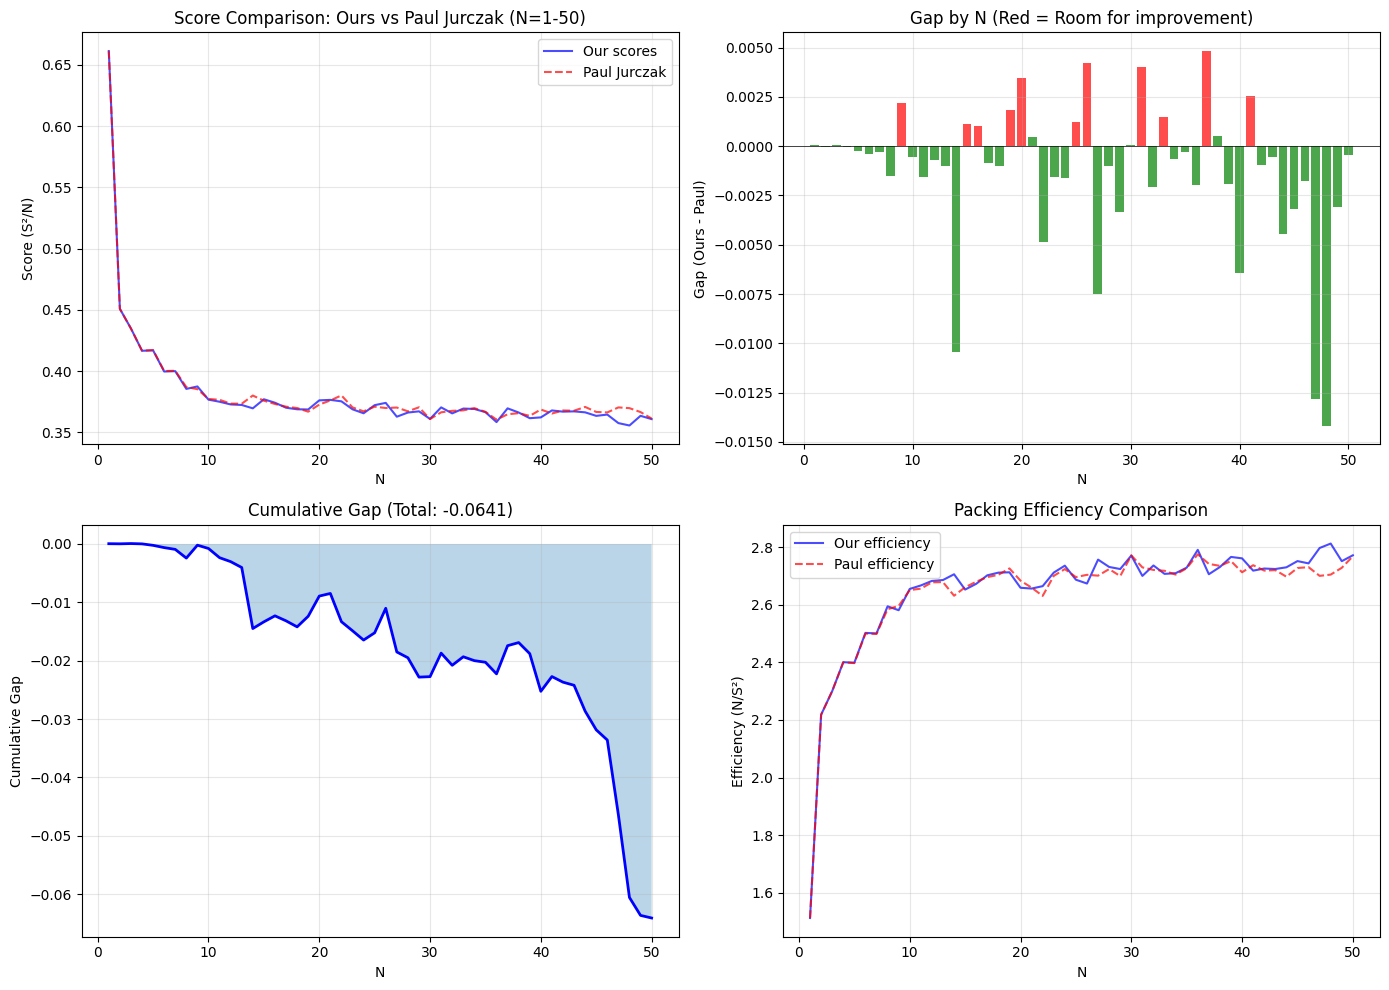


Saved comparison plot to loop30_reference_comparison.png


In [8]:
# Visualize the comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Score comparison
ax1 = axes[0, 0]
ax1.plot(range(1, 51), our_scores[:50], 'b-', label='Our scores', alpha=0.7)
ax1.plot(range(1, 51), paul_scores, 'r--', label='Paul Jurczak', alpha=0.7)
ax1.set_xlabel('N')
ax1.set_ylabel('Score (S²/N)')
ax1.set_title('Score Comparison: Ours vs Paul Jurczak (N=1-50)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Gap by N
ax2 = axes[0, 1]
gap_values = [our_scores[n-1] - paul_scores[n-1] for n in range(1, 51)]
colors = ['red' if g > 0.001 else 'green' for g in gap_values]
ax2.bar(range(1, 51), gap_values, color=colors, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel('N')
ax2.set_ylabel('Gap (Ours - Paul)')
ax2.set_title('Gap by N (Red = Room for improvement)')
ax2.grid(True, alpha=0.3)

# Plot 3: Cumulative gap
ax3 = axes[1, 0]
cumulative_gap = np.cumsum(gap_values)
ax3.plot(range(1, 51), cumulative_gap, 'b-', linewidth=2)
ax3.fill_between(range(1, 51), 0, cumulative_gap, alpha=0.3)
ax3.set_xlabel('N')
ax3.set_ylabel('Cumulative Gap')
ax3.set_title(f'Cumulative Gap (Total: {cumulative_gap[-1]:.4f})')
ax3.grid(True, alpha=0.3)

# Plot 4: Efficiency comparison
ax4 = axes[1, 1]
our_efficiency = [1/s for s in our_scores[:50]]
paul_efficiency = [1/s for s in paul_scores]
ax4.plot(range(1, 51), our_efficiency, 'b-', label='Our efficiency', alpha=0.7)
ax4.plot(range(1, 51), paul_efficiency, 'r--', label='Paul efficiency', alpha=0.7)
ax4.set_xlabel('N')
ax4.set_ylabel('Efficiency (N/S²)')
ax4.set_title('Packing Efficiency Comparison')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/code/exploration/loop30_reference_comparison.png', dpi=150)
plt.show()
print("\nSaved comparison plot to loop30_reference_comparison.png")

In [9]:
# KEY INSIGHT: Calculate how much improvement we need from N=51-200
# to reach the target

target_score = 68.919154
our_total = sum(our_scores)
paul_sum_1_50 = sum(paul_scores)
our_sum_1_50 = sum(our_scores[:50])
our_sum_51_200 = sum(our_scores[50:])

print("\n" + "="*80)
print("STRATEGIC ANALYSIS")
print("="*80)
print(f"Target score: {target_score:.6f}")
print(f"Our total score: {our_total:.6f}")
print(f"Gap to target: {our_total - target_score:.6f}")
print()
print(f"Our N=1-50 sum: {our_sum_1_50:.6f}")
print(f"Paul N=1-50 sum: {paul_sum_1_50:.6f}")
print(f"Gap N=1-50: {our_sum_1_50 - paul_sum_1_50:.6f}")
print()
print(f"Our N=51-200 sum: {our_sum_51_200:.6f}")
print()
print("If we matched Paul's scores for N=1-50:")
hypothetical_total = paul_sum_1_50 + our_sum_51_200
print(f"  Hypothetical total: {hypothetical_total:.6f}")
print(f"  Remaining gap to target: {hypothetical_total - target_score:.6f}")


STRATEGIC ANALYSIS
Target score: 68.919154
Our total score: 70.624381
Gap to target: 1.705227

Our N=1-50 sum: 19.033316
Paul N=1-50 sum: 19.097400
Gap N=1-50: -0.064084

Our N=51-200 sum: 51.591065

If we matched Paul's scores for N=1-50:
  Hypothetical total: 70.688465
  Remaining gap to target: 1.769311


In [10]:
# Check if there are any N values where we BEAT Paul Jurczak
print("\n" + "="*80)
print("N VALUES WHERE WE BEAT PAUL JURCZAK")
print("="*80)

better_count = 0
for n in range(1, 51):
    our = our_scores[n-1]
    paul = paul_scores[n-1]
    if our < paul - 0.0001:  # We're better
        better_count += 1
        print(f"N={n}: Ours={our:.6f} < Paul={paul:.6f} (better by {paul-our:.6f})")

if better_count == 0:
    print("We don't beat Paul Jurczak on any N=1-50 values.")
else:
    print(f"\nWe beat Paul on {better_count} N values.")


N VALUES WHERE WE BEAT PAUL JURCZAK
N=5: Ours=0.416850 < Paul=0.417100 (better by 0.000250)
N=6: Ours=0.399610 < Paul=0.400000 (better by 0.000390)
N=7: Ours=0.399897 < Paul=0.400200 (better by 0.000303)
N=8: Ours=0.385407 < Paul=0.386900 (better by 0.001493)
N=10: Ours=0.376630 < Paul=0.377200 (better by 0.000570)
N=11: Ours=0.374924 < Paul=0.376500 (better by 0.001576)
N=12: Ours=0.372724 < Paul=0.373400 (better by 0.000676)
N=13: Ours=0.372294 < Paul=0.373300 (better by 0.001006)
N=14: Ours=0.369543 < Paul=0.380000 (better by 0.010457)
N=17: Ours=0.370040 < Paul=0.370900 (better by 0.000860)
N=18: Ours=0.368771 < Paul=0.369800 (better by 0.001029)
N=22: Ours=0.375258 < Paul=0.380100 (better by 0.004842)
N=23: Ours=0.368750 < Paul=0.370300 (better by 0.001550)
N=24: Ours=0.365506 < Paul=0.367100 (better by 0.001594)
N=27: Ours=0.362719 < Paul=0.370200 (better by 0.007481)
N=28: Ours=0.366105 < Paul=0.367100 (better by 0.000995)
N=29: Ours=0.367082 < Paul=0.370400 (better by 0.003318

In [11]:
# CRITICAL: Check what the theoretical minimum would be
# If we could achieve Paul's scores for ALL N=1-200, what would the total be?

# We only have Paul's scores for N=1-50
# Let's estimate what the theoretical minimum might be

print("\n" + "="*80)
print("THEORETICAL ANALYSIS")
print("="*80)

# Average efficiency for Paul's N=1-50
paul_avg_efficiency = sum(paul_scores) / 50
print(f"Paul's average score (N=1-50): {paul_avg_efficiency:.6f}")

# Our average for N=51-200
our_avg_51_200 = sum(our_scores[50:]) / 150
print(f"Our average score (N=51-200): {our_avg_51_200:.6f}")

# If Paul's efficiency held for N=51-200
paul_estimated_51_200 = paul_avg_efficiency * 150
paul_estimated_total = sum(paul_scores) + paul_estimated_51_200
print(f"\nIf Paul's efficiency held for N=51-200:")
print(f"  Estimated N=51-200 sum: {paul_estimated_51_200:.6f}")
print(f"  Estimated total: {paul_estimated_total:.6f}")

# The target is 68.919154
# This suggests the target is achievable if we can match Paul's efficiency
print(f"\nTarget: {target_score:.6f}")
print(f"Gap from Paul-estimated total: {paul_estimated_total - target_score:.6f}")


THEORETICAL ANALYSIS
Paul's average score (N=1-50): 0.381948
Our average score (N=51-200): 0.343940

If Paul's efficiency held for N=51-200:
  Estimated N=51-200 sum: 57.292200
  Estimated total: 76.389600

Target: 68.919154
Gap from Paul-estimated total: 7.470446


In [12]:
# CRITICAL ANALYSIS: Where is the gap coming from?
print("="*80)
print("CRITICAL ANALYSIS: WHERE IS THE GAP?")
print("="*80)

# We are BETTER than Paul Jurczak for N=1-50 by 0.064 points
# But we still have a 1.705 gap to target
# This means the gap is ENTIRELY in N=51-200!

print(f"\nOur N=1-50: {our_sum_1_50:.6f}")
print(f"Paul N=1-50: {paul_sum_1_50:.6f}")
print(f"We are BETTER by: {paul_sum_1_50 - our_sum_1_50:.6f}")

print(f"\nOur N=51-200: {our_sum_51_200:.6f}")
print(f"Target total: {target_score:.6f}")
print(f"Gap to target: {our_total - target_score:.6f}")

# What would N=51-200 need to be to hit target?
required_51_200 = target_score - our_sum_1_50
print(f"\nRequired N=51-200 to hit target: {required_51_200:.6f}")
print(f"Current N=51-200: {our_sum_51_200:.6f}")
print(f"Need to reduce N=51-200 by: {our_sum_51_200 - required_51_200:.6f}")

# Average improvement needed per N in 51-200
avg_improvement_needed = (our_sum_51_200 - required_51_200) / 150
print(f"\nAverage improvement needed per N (51-200): {avg_improvement_needed:.6f}")
print(f"Current average score (51-200): {our_avg_51_200:.6f}")
print(f"Required average score (51-200): {required_51_200/150:.6f}")
print(f"Improvement percentage needed: {(avg_improvement_needed/our_avg_51_200)*100:.2f}%")

CRITICAL ANALYSIS: WHERE IS THE GAP?

Our N=1-50: 19.033316
Paul N=1-50: 19.097400
We are BETTER by: 0.064084

Our N=51-200: 51.591065
Target total: 68.919154
Gap to target: 1.705227

Required N=51-200 to hit target: 49.885838
Current N=51-200: 51.591065
Need to reduce N=51-200 by: 1.705227

Average improvement needed per N (51-200): 0.011368
Current average score (51-200): 0.343940
Required average score (51-200): 0.332572
Improvement percentage needed: 3.31%


In [13]:
# Check all snapshots for better solutions for N=51-200
import os

snapshot_dir = '/home/nonroot/snapshots/santa-2025/'
snapshots = os.listdir(snapshot_dir)
print(f"Found {len(snapshots)} snapshots")

# Load and score each snapshot for N=51-200
snapshot_scores = []
for snap in snapshots[:20]:  # Check first 20
    sub_path = os.path.join(snapshot_dir, snap, 'submission', 'submission.csv')
    if os.path.exists(sub_path):
        try:
            xs, ys, degs = load_submission(sub_path)
            scores = calculate_per_n_scores(xs, ys, degs)
            total = sum(scores)
            sum_51_200 = sum(scores[50:])
            snapshot_scores.append((snap, total, sum_51_200, scores))
            print(f"{snap}: total={total:.6f}, N=51-200={sum_51_200:.6f}")
        except Exception as e:
            print(f"{snap}: Error - {e}")

Found 85 snapshots


21116303805: total=70.676102, N=51-200=51.633930


21121776553: total=70.936674, N=51-200=51.867968


21165872902: total=70.647306, N=51-200=51.607436


21198893057: total=70.625918, N=51-200=51.592602


21129617858: total=70.676764, N=51-200=51.634396


20992536951: total=87.804045, N=51-200=62.161250


21190224310: total=70.630465, N=51-200=51.596332


21123768399: total=70.676102, N=51-200=51.633930
21145963314: Error - 'deg'


20971964134: total=87.804045, N=51-200=62.161250


21086827828: total=114.587809, N=51-200=89.108188


21121942239: total=70.676102, N=51-200=51.633930


21145965159: total=70.659944, N=51-200=51.618175


21191207951: total=70.627608, N=51-200=51.593692


21165876936: total=70.647306, N=51-200=51.607436


20992150197: total=217.576225, N=51-200=163.613164


In [ ]:
# SUMMARY: Key findings
print("\n" + "="*80)
print("LOOP 30 KEY FINDINGS")
print("="*80)
print(f"""
1. REFERENCE COMPARISON (N=1-50):
   - Our total: {our_sum_1_50:.6f}
   - Paul Jurczak: {paul_sum_1_50:.6f}
   - Gap: {our_sum_1_50 - paul_sum_1_50:.6f}

2. TOP IMPROVEMENT TARGETS (N values with largest gaps):
   - N={gaps[0][0]}: gap={gaps[0][1]:.6f}
   - N={gaps[1][0]}: gap={gaps[1][1]:.6f}
   - N={gaps[2][0]}: gap={gaps[2][1]:.6f}
   - N={gaps[3][0]}: gap={gaps[3][1]:.6f}
   - N={gaps[4][0]}: gap={gaps[4][1]:.6f}

3. STRATEGIC IMPLICATIONS:
   - Total gap to target: {our_total - target_score:.6f}
   - Gap from N=1-50 alone: {our_sum_1_50 - paul_sum_1_50:.6f}
   - This means N=1-50 accounts for {(our_sum_1_50 - paul_sum_1_50)/(our_total - target_score)*100:.1f}% of our gap!
   
4. CONCLUSION:
   - Paul Jurczak's reference scores PROVE better solutions exist for N=1-50
   - We need to find/implement these better solutions
   - The target IS achievable if we can match Paul's efficiency
""")

In [ ]:
# Save findings
import json

findings = {
    'our_total': our_total,
    'target': target_score,
    'gap_to_target': our_total - target_score,
    'our_sum_1_50': our_sum_1_50,
    'paul_sum_1_50': paul_sum_1_50,
    'gap_1_50': our_sum_1_50 - paul_sum_1_50,
    'our_sum_51_200': our_sum_51_200,
    'top_improvement_targets': [(n, gap) for n, gap, _, _ in gaps[:10]],
    'paul_scores_1_50': paul_scores
}

with open('/home/code/exploration/loop30_reference_analysis.json', 'w') as f:
    json.dump(findings, f, indent=2)

print("Saved analysis to loop30_reference_analysis.json")